## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

from keras.callbacks import ModelCheckpoint
from neural_networks.fcrn import FCRN_A
from utils.data.data_generator import DataGenerator
from utils.data.data_ops import move_val_split_to_train
from utils.data.data_ops import create_val_split_from_train
from utils.input_output.io import read_json, write_json
from utils.visualization.vis import plot_logs

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load the dataset

#### Create validation split from the initial training data

In [4]:
move_val_split_to_train(config.VAL_PATH, config.TRAIN_PATH)
create_val_split_from_train(config.TRAIN_PATH, config.VAL_PATH, config.VAL_SIZE, config.RAND_SEED)

In [5]:
params = {
    'dim': config.DIM,
    'batch_size': config.BATCH_SIZE,
    'shuffle': config.SHUFFLE
}

In [6]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **params)

## 3. Instantiate a FCRN_A

In [7]:
model = FCRN_A(loss_name=config.LOSS_NAME)

## 4. Train the model

In [8]:
!rm -rf $config.CHECKPOINTS_PATH
!rm -rf $config.LOGS_PATH
os.makedirs(config.CHECKPOINTS_PATH)
os.makedirs(config.LOGS_PATH)

In [9]:
%%time
model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   verbose=0,
                                   save_best_only=True)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.EPOCHS,
                                    callbacks=[model_checkpoint])

Epoch 1/30
2/2 [==============================] - 10s 5s/step - loss: 0.4660 - mae_keras: 242.9455 - rmse_keras: 250.6253 - underestimate_keras: 131.1206 - overestimate_keras: 7.5461 - difference_keras: 138.6667 - val_loss: 0.3319 - val_mae_keras: 216.7907 - val_rmse_keras: 227.0940 - val_underestimate_keras: 122.1141 - val_overestimate_keras: 0.0000e+00 - val_difference_keras: 122.1141
Epoch 2/30
2/2 [==============================] - 3s 1s/step - loss: 0.2737 - mae_keras: 129.3022 - rmse_keras: 137.2624 - underestimate_keras: 71.1693 - overestimate_keras: 0.6958 - difference_keras: 71.8651 - val_loss: 0.2202 - val_mae_keras: 40.9723 - val_rmse_keras: 44.5689 - val_underestimate_keras: 0.9671 - val_overestimate_keras: 22.1118 - val_difference_keras: 23.0789
Epoch 3/30
2/2 [==============================] - 2s 1s/step - loss: 0.2143 - mae_keras: 47.9338 - rmse_keras: 55.5663 - underestimate_keras: 14.8617 - overestimate_keras: 10.9809 - difference_keras: 25.8425 - val_loss: 0.2017 - va

Epoch 23/30
2/2 [==============================] - 3s 1s/step - loss: 0.0850 - mae_keras: 14.6294 - rmse_keras: 17.3782 - underestimate_keras: 6.8726 - overestimate_keras: 1.7195 - difference_keras: 8.5921 - val_loss: 0.0850 - val_mae_keras: 37.7948 - val_rmse_keras: 41.0503 - val_underestimate_keras: 21.2891 - val_overestimate_keras: 0.0000e+00 - val_difference_keras: 21.2891
Epoch 24/30
2/2 [==============================] - 2s 1s/step - loss: 0.0840 - mae_keras: 27.8676 - rmse_keras: 30.6908 - underestimate_keras: 14.9270 - overestimate_keras: 0.0441 - difference_keras: 14.9711 - val_loss: 0.0836 - val_mae_keras: 7.6111 - val_rmse_keras: 9.5998 - val_underestimate_keras: 1.0904 - val_overestimate_keras: 3.1968 - val_difference_keras: 4.2872
Epoch 25/30
2/2 [==============================] - 2s 1s/step - loss: 0.0807 - mae_keras: 13.9708 - rmse_keras: 16.1928 - underestimate_keras: 6.5758 - overestimate_keras: 1.0842 - difference_keras: 7.6600 - val_loss: 0.0798 - val_mae_keras: 33.5

#### Save and load train stats/logs/history

In [10]:
logs = model.history.history.copy()

logs['train_loss'] = logs.pop('loss')
logs['train_mae'] = logs.pop('mae_keras')
logs['val_mae'] = logs.pop('val_mae_keras')
logs['train_rmse'] = logs.pop('rmse_keras')
logs['val_rmse'] = logs.pop('val_rmse_keras')
logs['train_underestimate'] = logs.pop('underestimate_keras')
logs['val_underestimate'] = logs.pop('val_underestimate_keras')
logs['train_overestimate'] = logs.pop('overestimate_keras')
logs['val_overestimate'] = logs.pop('val_overestimate_keras')
logs['train_difference'] = logs.pop('difference_keras')
logs['val_difference'] = logs.pop('val_difference_keras')

logs['train_size'] = train_generator.get_size()
logs['val_size'] = val_generator.get_size()
logs['rand_seed'] = config.RAND_SEED
logs['shuffle'] = config.SHUFFLE
logs['loss_name'] = config.LOSS_NAME
logs['input_dim'] = config.DIM
logs['density_map_sigma'] = config.GT_SIGMA
logs['density_map_multiplication_factor'] = config.DENSITY_MAP_MULTIPLICATION_FACTOR
logs['sub_experiment_name'] = config.SUB_EXPERIMENT_NAME

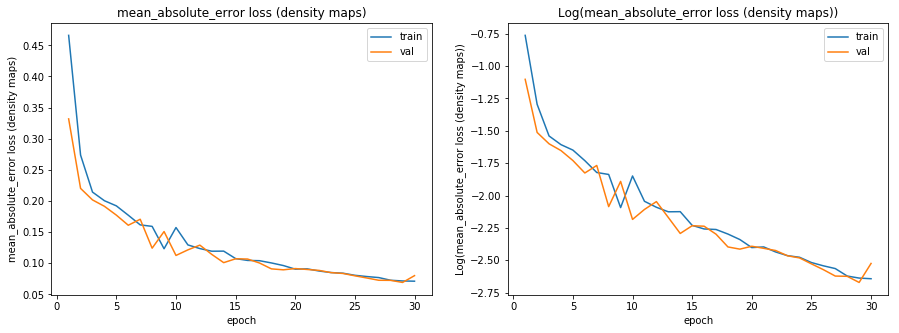

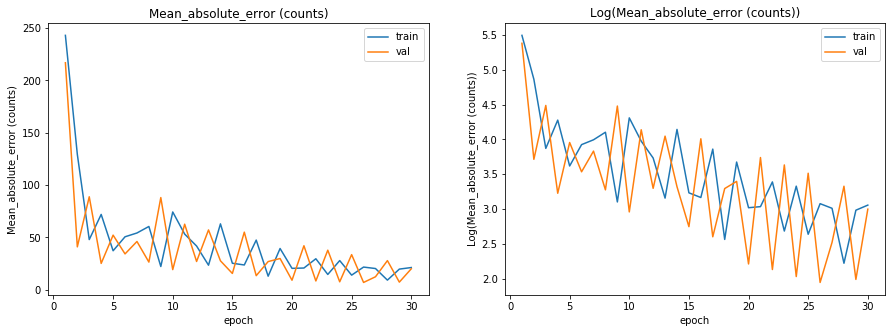

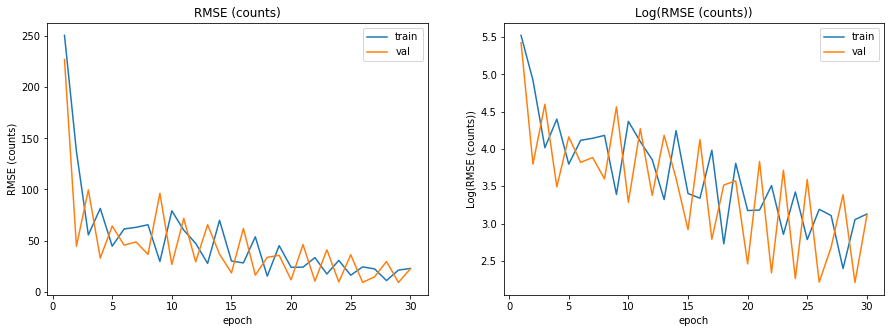

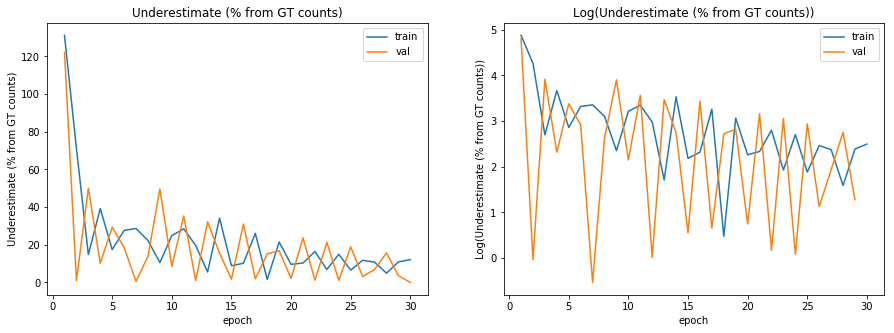

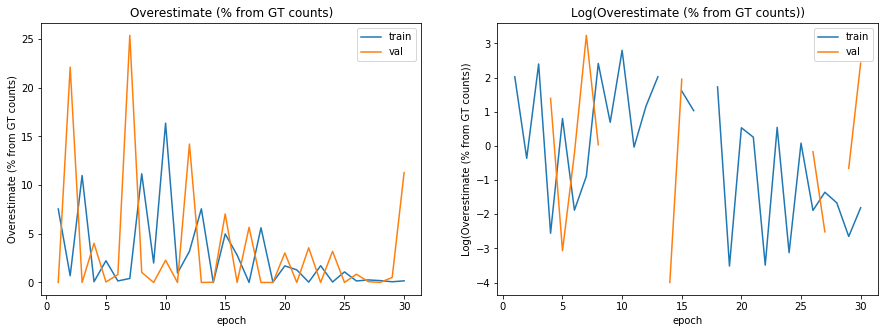

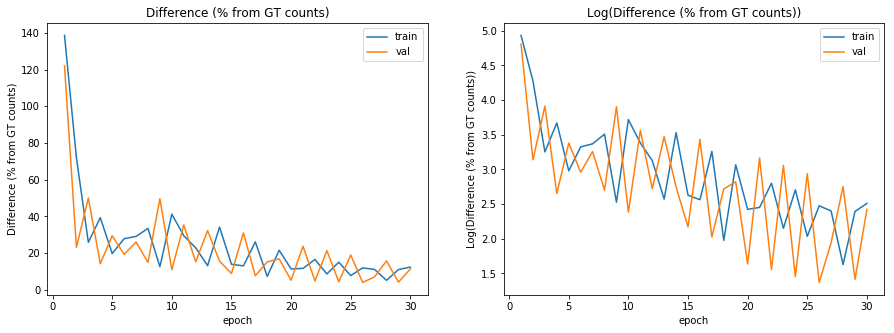

In [11]:
write_json(logs, config.LOGS_FILENAME)
logs = read_json(config.LOGS_FILENAME)

plot_logs(logs['train_loss'], logs['val_loss'], f'{config.LOSS_NAME} loss (density maps)')
plot_logs(logs['train_mae'], logs['val_mae'], f'Mean_absolute_error (counts)')
plot_logs(logs['train_rmse'], logs['val_rmse'], f'RMSE (counts)')
plot_logs(logs['train_underestimate'], logs['val_underestimate'], f'Underestimate (% from GT counts)')
plot_logs(logs['train_overestimate'], logs['val_overestimate'], f'Overestimate (% from GT counts)')
plot_logs(logs['train_difference'], logs['val_difference'], f'Difference (% from GT counts)')